# Test 4 with Optuna optimization

In [4]:
%load_ext autoreload
%autoreload
from test4 import *

TEST_ID = 4
COST = Cost4
MODEL = Model4()

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # Limit the verbosity of Optuna

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. HillClimbing Radar

In [5]:
number_of_tests = 3 # repeat each configuration 3 times and take mean values

def objective(trial):
    # Define the parameter search space for Optuna
    num_samples = trial.suggest_int("num_samples", 1, 10)
    patience = trial.suggest_int("patience", 1, 1000)
    static_perturbation_factor = trial.suggest_float("static_perturbation_factor", 1e-6, 10)
    dynamic_perturbation_factor = trial.suggest_float("dynamic_perturbation_factor", 1.0, 10.0)
    inflation_vector_max_perturbation = trial.suggest_float("inflation_vector_max_perturbation", 1.0, 100.0)

    # Initialize the attack
    attack = HillClimbing(estimator=MODEL, verbose=0)
    neighborhood = Radar(constraints)
    
    # Try running the test with selected parameters
    try:
        score = list()
        queries = list()
        for _ in range(number_of_tests):
            _, s, _, q = run_test(
                test_id=TEST_ID,
                verbose=False,
                show_graph=False,
                save_graph=False,
                num_samples=num_samples,
                attack=attack,
                neighborhood=neighborhood,
                targeted=True,
                specific_class=0,
                patience=patience,
                cost_function=COST,
                static_perturbation_factor=static_perturbation_factor,
                dynamic_perturbation_factor=dynamic_perturbation_factor,
                enable_negative_inflation_vector=True,
                inflation_vector_max_perturbation=inflation_vector_max_perturbation
            )
            score.append(s)
            queries.append(q)
        sc = np.mean(score)
        total_queries = np.mean(queries)
    except Exception as e:
        return float("inf")  # Return high value if an error occurs

    # If the score is 100%, we then would like to minimize number of queries.
    if sc >= 1.0:
        sc -= total_queries
    return 1 - sc  # Objective to minimize

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

# Print the best parameters and result
print("Best parameters:", study.best_params)
print("Best score:", 1 - study.best_value)

Best parameters: {'num_samples': 9, 'patience': 382, 'static_perturbation_factor': 2.994913683982775, 'dynamic_perturbation_factor': 4.6240303756203645, 'inflation_vector_max_perturbation': 86.19550262540363}
Best score: -inf


In [34]:
optuna.importance.get_param_importances(study)

{'num_samples': 0.38183335218980063,
 'static_perturbation_factor': 0.27452008760213825,
 'inflation_vector_max_perturbation': 0.24591062864065577,
 'patience': 0.06259253061050822,
 'dynamic_perturbation_factor': 0.035143400956897074}

In [6]:
# Retrieve the best parameters from the Optuna study
best_params = study.best_params

# Run the test with verbose output and graph options enabled
_, score, total_time, total_queries = run_test(
    test_id=TEST_ID,
    verbose=True,
    show_graph=True,
    save_graph=True,
    num_samples=best_params["num_samples"],
    attack=HillClimbing(estimator=MODEL, verbose=1),
    neighborhood=Radar(constraints),
    targeted=False,
    patience=best_params["patience"],
    cost_function=COST,
    static_perturbation_factor=best_params["static_perturbation_factor"],
    dynamic_perturbation_factor=best_params["dynamic_perturbation_factor"],
    enable_negative_inflation_vector=True,
    inflation_vector_max_perturbation=best_params["inflation_vector_max_perturbation"]
)

# Display results
print("Final run results:")
print("Score:", score)
print("Total time:", total_time)
print("Total queries:", total_queries)

TypeError: only length-1 arrays can be converted to Python scalars

## 2. SimulatedAnnealing Radar

Score: 0.0
Total time: 0.027000904083251953
Number of queries: 9


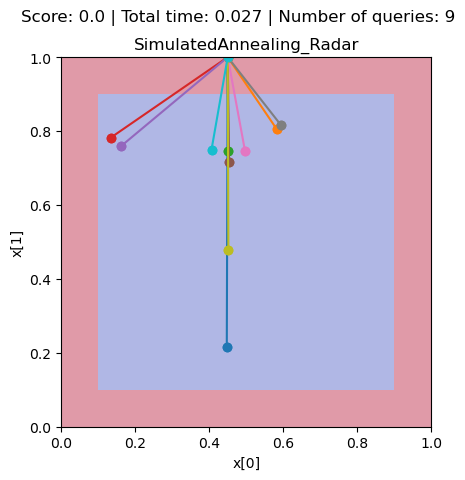

(4, 0.0, 0.027000904083251953, 9)

In [21]:
run_test(attack=SimulatedAnnealing(estimator=MODEL, verbose=0), name="SimulatedAnnealing_Radar")

C:\Users\allem\OneDrive - Université Libre de Bruxelles\MA2-IRIFS\Q1\MEMOIRE\Thesis - Temp repository\neighborhoods\Radar.py:159: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: inflation_vector_max_perturbation / (1 + np.exp(-x))


Best parameters: {'static_perturbation_factor': 40.1204785462579, 'dynamic_perturbation_factor': 1.7108426686305314, 'patience': 374, 'initial_temperature': 2277.1317134239125, 'final_temperature': 0.6669323014774688, 'cooling_rate': 0.7469781574115184, 'inflation_vector_max_perturbation': 10.308999903131978}
Best score: 0.0


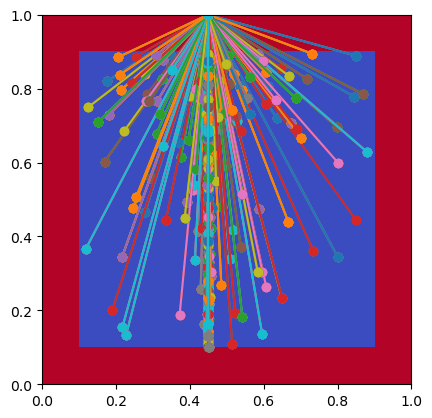

In [31]:
number_of_tests = 3 # repeat each configuration n times and take mean values

def objective(trial):
    # Define the parameter search space for Optuna
    static_perturbation_factor = trial.suggest_float(
        "static_perturbation_factor", 1e-8, 100, log=False
    )
    dynamic_perturbation_factor = trial.suggest_float(
        "dynamic_perturbation_factor", 1.0, 5.0
    )
    patience = trial.suggest_int("patience", 1, 1000)
    initial_temperature = trial.suggest_float(
        "initial_temperature", 1.0, 10000.0, log=False
    )
    final_temperature = trial.suggest_float(
        "final_temperature", 1e-12, 0.99, log=False
    )
    cooling_rate = trial.suggest_float("cooling_rate", 0.50, 0.999)
    inflation_vector_max_perturbation = trial.suggest_float(
        "inflation_vector_max_perturbation", 1.0, 100.0
    )

    # Initialize the attack
    attack = SimulatedAnnealing(estimator=MODEL, verbose=0)
    neighborhood = Radar(constraints)
    
    # Try running the test with selected parameters
    try:
        score = list()
        queries = list()
        for _ in range(number_of_tests):
            _, s, _, q = run_test(
                test_id=TEST_ID,
                name="SimulatedAnnealing_Radar",
                verbose=False,
                show_graph=False,
                save_graph=False,
                num_samples=3,
                attack=attack,
                neighborhood=neighborhood,
                targeted=True,
                specific_class=0,
                patience=patience,
                cost_function=COST,
                static_perturbation_factor=static_perturbation_factor,
                dynamic_perturbation_factor=dynamic_perturbation_factor,
                enable_negative_inflation_vector=True,
                inflation_vector_max_perturbation=inflation_vector_max_perturbation,
                
                initial_temperature=initial_temperature,
                final_temperature=final_temperature,
                cooling_rate=cooling_rate,
            )
            score.append(s)
            queries.append(q)
        sc = np.mean(score)
        total_queries = np.mean(queries)
    
    except Exception as e:
        return float("inf")  # Return a high value if an error occurs

    # If the score is 100%, we then would like to minimize number of queries.
    if sc >= 1.0:
        sc -= total_queries
    return 1 - sc  # Objective to minimize

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

# Print the best parameters and result
print("Best parameters:", study.best_params)
print("Best score:", 1 - study.best_value)

In [32]:
optuna.importance.get_param_importances(study)

RuntimeError: Encountered zero total variance in all trees.

In [25]:
# Retrieve the best parameters from the Optuna study
best_params = study.best_params

# Run the test with verbose output and graph options enabled
_, score, total_time, total_queries = run_test(
    test_id=TEST_ID,
    name="SimulatedAnnealing_Radar",
    verbose=True,
    show_graph=True,
    save_graph=True,
    num_samples=200,
    attack=SimulatedAnnealing(estimator=MODEL, verbose=0),
    neighborhood=Radar(constraints),
    targeted=False,
    patience=best_params["patience"],
    cost_function=COST,
    static_perturbation_factor=best_params["static_perturbation_factor"],
    dynamic_perturbation_factor=best_params["dynamic_perturbation_factor"],
    enable_negative_inflation_vector=True,
    inflation_vector_max_perturbation=best_params["inflation_vector_max_perturbation"],
    
    initial_temperature=best_params["initial_temperature"],
    final_temperature=best_params["final_temperature"],
    cooling_rate=best_params["cooling_rate"],
)

# Display results
print("Final run results:")
print("Score:", score)
print("Total time:", total_time)
print("Total queries:", total_queries)

Exception: RADAR: No valid sample satisfied the constraints after 10000 trials.

# 3. TabuSeach Radar

Score: 0.0
Total time: 0.08899998664855957
Number of queries: 293


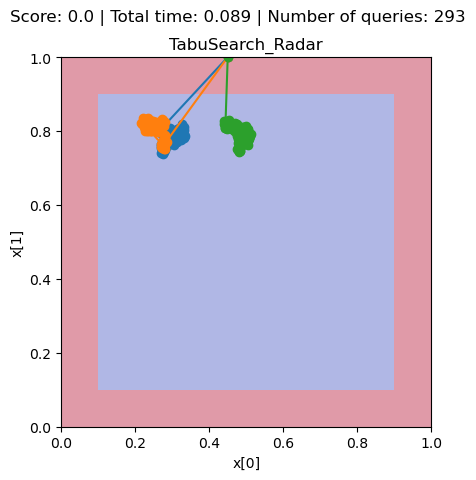

(4, 0.0, 0.08899998664855957, 293)

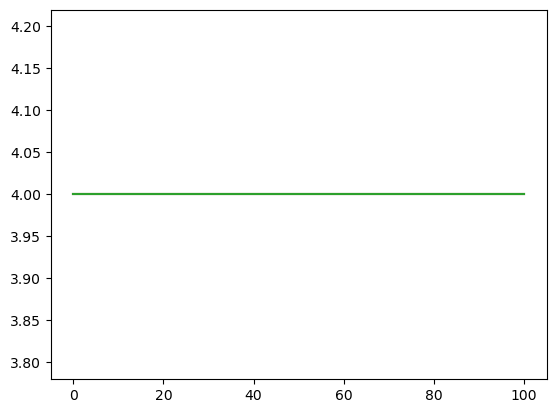

In [26]:
run_test(attack=TabuSearch(estimator=MODEL, verbose=0), name="TabuSearch_Radar", num_samples=3, plot_history=True)

Best parameters: {'static_perturbation_factor': 0.08584502974751584, 'dynamic_perturbation_factor': 1.6952773594922936, 'patience': 630, 'tabu_tenure': 13, 'max_tabu_size': 373, 'similarity_epsilon': 1.637780606916303e-07, 'inflation_vector_max_perturbation': 9.284981170004537}
Best score: 0.6666666666666666


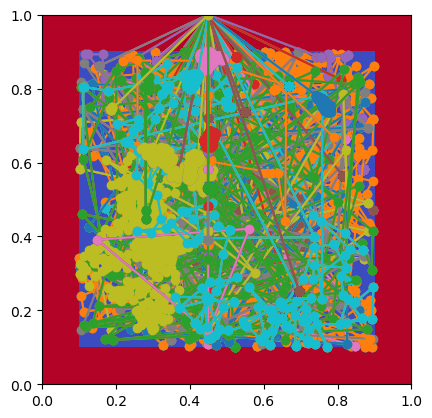

In [27]:
number_of_tests = 3 # repeat each configuration n times and take mean values

def objective(trial):
    # Define the parameter search space for Optuna
    static_perturbation_factor = trial.suggest_float(
        "static_perturbation_factor", 1e-8, 100, log=True
    )
    dynamic_perturbation_factor = trial.suggest_float(
        "dynamic_perturbation_factor", 1.0, 5.0
    )
    patience = trial.suggest_int("patience", 1, 1000)
    tabu_tenure = trial.suggest_int("tabu_tenure", 5, 50)
    max_tabu_size = trial.suggest_int("max_tabu_size", 50, 500)
    similarity_epsilon = trial.suggest_float(
        "similarity_epsilon", 1e-8, 1, log=True
    )
    
    inflation_vector_max_perturbation = trial.suggest_float(
        "inflation_vector_max_perturbation", 1.0, 100.0
    )

    # Initialize the attack
    attack = TabuSearch(estimator=MODEL, verbose=0)
    neighborhood = Radar(constraints)
    
    # Try running the test with selected parameters
    try:
        score = list()
        queries = list()
        for _ in range(number_of_tests):
            _, s, _, q = run_test(
                test_id=TEST_ID,
                name="TabuSearch_Radar",
                verbose=False,
                show_graph=False,
                save_graph=False,
                num_samples=1,
                attack=attack,
                neighborhood=neighborhood,
                targeted=True,
                specific_class=0,
                patience=patience,
                cost_function=COST,
                static_perturbation_factor=static_perturbation_factor,
                dynamic_perturbation_factor=dynamic_perturbation_factor,
                enable_negative_inflation_vector=True,
                inflation_vector_max_perturbation=inflation_vector_max_perturbation,
                
                tabu_tenure=tabu_tenure,
                max_tabu_size=max_tabu_size,
                similarity_epsilon=similarity_epsilon,
            )
            score.append(s)
            queries.append(q)
        sc = np.mean(score)
        total_queries = np.mean(queries)
    
    except Exception as e:
        return float("inf")  # Return a high value if an error occurs

    # If the score is 100%, we then would like to minimize number of queries.
    if sc >= 1.0:
        sc -= total_queries
    return 1 - sc  # Objective to minimize

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

# Print the best parameters and result
print("Best parameters:", study.best_params)
print("Best score:", 1 - study.best_value)

In [30]:
optuna.importance.get_param_importances(study)

{'inflation_vector_max_perturbation': 0.5997667737309789,
 'static_perturbation_factor': 0.16975795621685463,
 'patience': 0.13537180668318563,
 'tabu_tenure': 0.06448080692040742,
 'similarity_epsilon': 0.028881261606734068,
 'max_tabu_size': 0.0017413948412287185,
 'dynamic_perturbation_factor': 6.10753072415657e-13}

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Score: 1.0
Total time: 0.8710160255432129
Number of queries: 2369


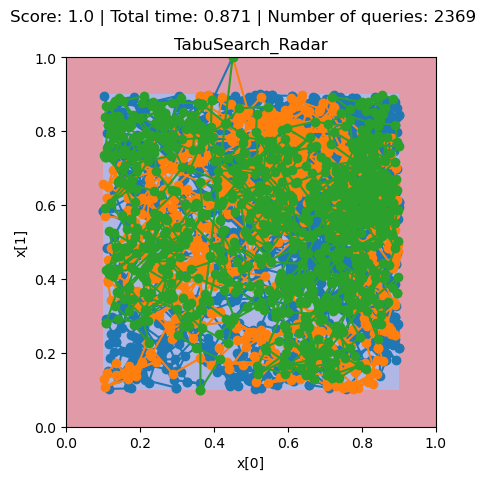

Final run results:
Score: 1.0
Total time: 0.8710160255432129
Total queries: 2369


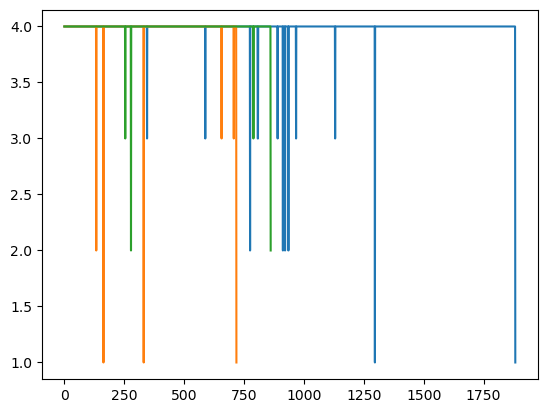

In [29]:
# Retrieve the best parameters from the Optuna study
best_params = study.best_params

# Run the test with verbose output and graph options enabled
_, score, total_time, total_queries = run_test(
    test_id=TEST_ID,
    name="TabuSearch_Radar",
    verbose=True,
    show_graph=True,
    save_graph=True,
    num_samples=3,
    attack=TabuSearch(estimator=MODEL, verbose=1),
    neighborhood=Radar(constraints),
    targeted=False,
    patience=best_params["patience"],
    cost_function=COST,
    static_perturbation_factor=best_params["static_perturbation_factor"],
    dynamic_perturbation_factor=best_params["dynamic_perturbation_factor"],
    enable_negative_inflation_vector=True,
    inflation_vector_max_perturbation=best_params["inflation_vector_max_perturbation"],
    
    tabu_tenure=best_params["tabu_tenure"],
    max_tabu_size=best_params["max_tabu_size"],
    similarity_epsilon=best_params["similarity_epsilon"],
    
    plot_history=True
)

# Display results
print("Final run results:")
print("Score:", score)
print("Total time:", total_time)
print("Total queries:", total_queries)